# Categorical and mixed type data drift detection on income prediction

### Method

The drift detector applies feature-wise two-sample [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (K-S) tests for the continuous numerical features and [Chi-Squared](https://en.wikipedia.org/wiki/Chi-squared_test) tests for the categorical features. For multivariate data, the obtained p-values for each feature are aggregated either via the [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) or the [False Discovery Rate](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf) (FDR) correction. The Bonferroni correction is more conservative and controls for the probability of at least one false positive. The FDR correction on the other hand allows for an expected fraction of false positives to occur.



### Dataset

The instances contain a person's characteristics like age, marital status or education while the label represents whether the person makes more or less than $50k per year. The dataset consists of a mixture of numerical and categorical features. It is fetched using the [Alibi](https://github.com/SeldonIO/alibi) library, which can be installed with pip: 

```bash
pip install alibi
```

In [1]:
import alibi
import matplotlib.pyplot as plt
import numpy as np

from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.utils.saving import save_detector, load_detector

### Load income prediction dataset

The ```fetch_adult``` function returns a ```Bunch``` object containing the instances, the targets, the feature names and a dictionary with as keys the column indices of the categorical features and as values the possible categories for each categorical variable.

In [2]:
adult = alibi.datasets.fetch_adult()
X, y = adult.data, adult.target
feature_names = adult.feature_names
category_map = adult.category_map
X.shape, y.shape

((32561, 12), (32561,))

We split the data in a reference set and 2 test sets on which we test the data drift:

In [3]:
n_ref = 10000
n_test = 10000

X_ref, X_t0, X_t1 = X[:n_ref], X[n_ref:n_ref + n_test], X[n_ref + n_test:n_ref + 2 * n_test]
X_ref.shape, X_t0.shape, X_t1.shape

((10000, 12), (10000, 12), (10000, 12))

### Detect drift

We need to provide the drift detector with the columns which contain categorical features so it knows which features require the Chi-Squared and which ones require the K-S univariate test. We can either provide a dict with as keys the column indices and as values the number of possible categories or just set the values to *None* and let the detector infer the number of categories from the reference data as in the example below:

In [4]:
categories_per_feature = {f: None for f in list(category_map.keys())}

Initialize the detector:

In [5]:
cd = TabularDrift(p_val=.05, X_ref=X_ref, categories_per_feature=categories_per_feature)

We can also save/load an initialised detector:

In [6]:
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

Now we can check whether the 2 test sets are drifting from the reference data:

In [7]:
preds = cd.predict(X_t0)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


Let's take a closer look at each of the features. The `preds` dictionary also returns the K-S or Chi-Squared test statistics and p-value for each feature:

In [8]:
for f in range(cd.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Age -- K-S 0.012 -- p-value 0.512
Workclass -- Chi2 16.219 -- p-value 0.039
Education -- Chi2 9.234 -- p-value 0.161
Marital Status -- Chi2 6.089 -- p-value 0.107
Occupation -- Chi2 16.074 -- p-value 0.041
Relationship -- Chi2 0.974 -- p-value 0.965
Race -- Chi2 1.179 -- p-value 0.882
Sex -- Chi2 0.461 -- p-value 0.497
Capital Gain -- K-S 0.002 -- p-value 1.000
Capital Loss -- K-S 0.002 -- p-value 1.000
Hours per week -- K-S 0.012 -- p-value 0.512
Country -- Chi2 19.993 -- p-value 0.029


Although the p-values of some individual features are below the threshold, they are still above the threshold after multivariate correction: 

In [9]:
preds['data']['threshold']

0.004166666666666667

If you are interested in individual feature-wise drift, this is also possible:

In [10]:
fpreds = cd.predict(X_t0, drift_type='feature')

In [11]:
for f in range(cd.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    is_drift = fpreds['data']['is_drift'][f]
    stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Age -- Drift? No! -- K-S 0.012 -- p-value 0.512
Workclass -- Drift? Yes! -- Chi2 16.219 -- p-value 0.039
Education -- Drift? No! -- Chi2 9.234 -- p-value 0.161
Marital Status -- Drift? No! -- Chi2 6.089 -- p-value 0.107
Occupation -- Drift? Yes! -- Chi2 16.074 -- p-value 0.041
Relationship -- Drift? No! -- Chi2 0.974 -- p-value 0.965
Race -- Drift? No! -- Chi2 1.179 -- p-value 0.882
Sex -- Drift? No! -- Chi2 0.461 -- p-value 0.497
Capital Gain -- Drift? No! -- K-S 0.002 -- p-value 1.000
Capital Loss -- Drift? No! -- K-S 0.002 -- p-value 1.000
Hours per week -- Drift? No! -- K-S 0.012 -- p-value 0.512
Country -- Drift? Yes! -- Chi2 19.993 -- p-value 0.029


What about the second test set?

In [12]:
preds = cd.predict(X_t1)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? Yes!


We can again investigate the individual features:

In [13]:
for f in range(cd.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Age -- Drift? No! -- K-S 0.007 -- p-value 0.967
Workclass -- Drift? No! -- Chi2 8.742 -- p-value 0.365
Education -- Drift? No! -- Chi2 10.579 -- p-value 0.102
Marital Status -- Drift? No! -- Chi2 2.333 -- p-value 0.506
Occupation -- Drift? Yes! -- Chi2 25.039 -- p-value 0.002
Relationship -- Drift? No! -- Chi2 13.250 -- p-value 0.021
Race -- Drift? No! -- Chi2 2.794 -- p-value 0.593
Sex -- Drift? No! -- Chi2 0.022 -- p-value 0.882
Capital Gain -- Drift? No! -- K-S 0.005 -- p-value 0.999
Capital Loss -- Drift? No! -- K-S 0.003 -- p-value 1.000
Hours per week -- Drift? No! -- K-S 0.004 -- p-value 1.000
Country -- Drift? No! -- Chi2 24.140 -- p-value 0.007


It seems like there is divergence in the distribution of the *Occupation* feature between the reference and test set. Let's visualize this:

In [14]:
def plot_categories(idx: int) -> None:
    # reference data
    fref_drift = {cat: cd.X_ref_count[idx][i] for i, cat in enumerate(category_map[idx])}
    
    # test set
    cats = {f: list(np.unique(X_t1[:, f])) for f in categories_per_feature.keys()}
    X_count = {f: [(X_t1[:, f] == v).sum() for v in vals] for f, vals in cats.items()}
    fxt1_drift = {cat: X_count[idx][i] for i, cat in enumerate(category_map[idx])}
    
    # plot bar chart
    plot_labels = list(fxt1_drift.keys())
    ind = np.arange(len(plot_labels))
    width = .35
    fig, ax = plt.subplots()
    p1 = ax.bar(ind, list(fref_drift.values()), width)
    p2 = ax.bar(ind + width, list(fxt1_drift.values()), width)
    ax.set_title(f'Counts per category for {feature_names[idx]} feature')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(plot_labels)
    ax.legend((p1[0], p2[0]), ('Reference', 'Test'), loc='upper right', ncol=2)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Categories')
    plt.xticks(list(np.arange(len(plot_labels))), plot_labels, rotation='vertical')
    plt.show()

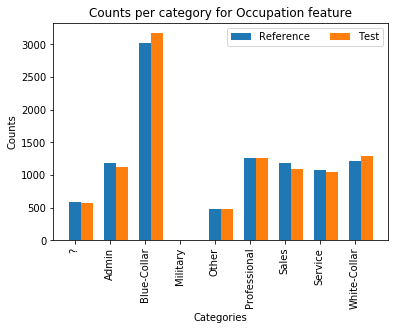

In [15]:
idx_drift = np.where(preds['data']['p_val'] < preds['data']['threshold'])[0][0]

plot_categories(idx_drift)

While these distributions might not look too dissimilar, let's compare it to for instance the *Workclass*, *Education* or *Marital Status* features, which do not show individual feature drift:

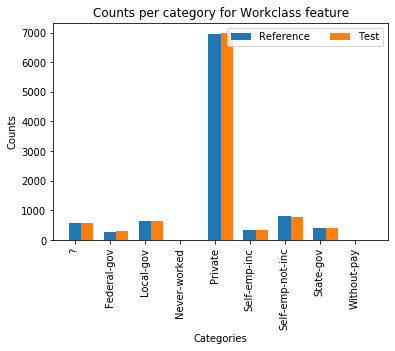

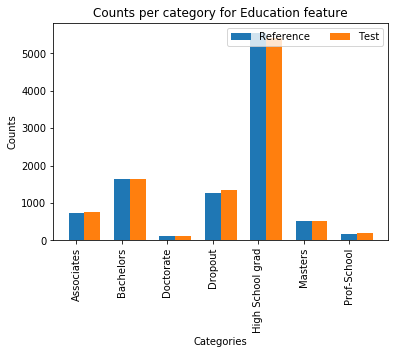

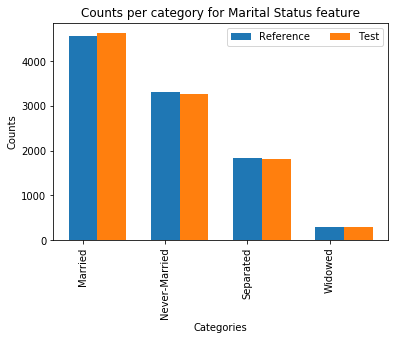

In [16]:
plot_categories(1)
plot_categories(2)
plot_categories(3)

### Categorical data drift

While the *TabularDrift* detector works fine with numerical or categorical features only, we can also directly use a categorical drift detector. In this case, we don't need to specify the categorical feature columns. First we construct a categorical-only dataset and then use the *ChiSquareDrift* detector:

In [17]:
cols = list(category_map.keys())
cat_names = [feature_names[_] for _ in list(category_map.keys())]
X_ref_cat, X_t0_cat = X_ref[:, cols], X_t0[:, cols]
X_ref_cat.shape, X_t0_cat.shape

((10000, 8), (10000, 8))

In [18]:
cd = ChiSquareDrift(p_val=.05, X_ref=X_ref_cat)
preds = cd.predict(X_t0_cat)
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


In [19]:
print(f"Threshold {preds['data']['threshold']}")
for f in range(cd.n_features):
    fname = cat_names[f]
    is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Threshold 0.00625
Workclass -- Drift? No! -- Chi2 16.219 -- p-value 0.039
Education -- Drift? No! -- Chi2 9.234 -- p-value 0.161
Marital Status -- Drift? No! -- Chi2 6.089 -- p-value 0.107
Occupation -- Drift? No! -- Chi2 16.074 -- p-value 0.041
Relationship -- Drift? No! -- Chi2 0.974 -- p-value 0.965
Race -- Drift? No! -- Chi2 1.179 -- p-value 0.882
Sex -- Drift? No! -- Chi2 0.461 -- p-value 0.497
Country -- Drift? No! -- Chi2 19.993 -- p-value 0.029
